In [ ]:
!wget --keep-session-cookies --save-cookies=cookies.txt --post-data "username=m2400232@edu.misis.ru&password=1JK12.8S321k&submit=Login" https://www.cityscapes-dataset.com/login/
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3

In [ ]:
!unzip gtFine_trainvaltest.zip

In [ ]:
!mkdir images || mv leftImg8bit_trainvaltest.zip images/
!cd images && unzip leftImg8bit_trainvaltest.zip

In [ ]:
!pip install tensorflow-rocm keras opencv-python matplotlib scikit-learn

In [1]:
import numpy as np
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt

train_img = "images/leftImg8bit/train/**/*.png"
train_annotations = "gtFine/train/**/*_gtFine_labelIds.png"
val_img = "images/leftImg8bit/val/**/*.png"
val_annotations = "gtFine/val/**/*_gtFine_labelIds.png"
test_img = "images/leftImg8bit/val/**/*.png"
test_annotations = "gtFine/test/**/*_gtFine_labelIds.png"


COLOR_MAP = { # TODO: Fix color map if needed
    (0, 0, 0): 0,       # unlabeled
    (0, 0, 1): 1,       # ego vehicle
    (0, 0, 2): 2,       # rectification border
    (0, 0, 3): 3,       # out of roi
    (0, 0, 4): 4,       # static
    (0, 0, 5): 5,
    (81, 0, 81): 6,     # ground
    (128, 64, 128): 7,  # road
    (244, 35, 232): 8,  # sidewalk
    (250, 170, 160): 9, # parking
    (230, 150, 140): 10,# rail track
    (70, 70, 70): 11,   # building
    (102, 102, 156): 12,# wall
    (190, 153, 153): 13,# fence
    (180, 165, 180): 14,# guard rail
    (150, 100, 100): 15,# bridge
    (150, 120, 90): 16, # tunnel
    (153, 153, 153): 17,# pole
    (153, 153, 153): 18,# polegroup
    (250, 170, 30): 19, # traffic light
    (220, 220, 0): 20,  # traffic sign
    (107, 142, 35): 21, # vegetation
    (152, 251, 152): 22,# terrain
    (70, 130, 180): 23, # sky
    (220, 20, 60): 24,  # person
    (255, 0, 0): 25,    # rider
    (0, 0, 142): 26,    # car
    (0, 0, 70): 27,     # truck
    (0, 60, 100): 28,   # bus
    (0, 0, 90): 29,     # caravan
    (0, 0, 110): 30,    # trailer
    (0, 80, 100): 31,   # train
    (0, 0, 230): 32,    # motorcycle
    (119, 11, 32): 33,   # bicycle
    (0, 0, 6): 34,       # static
}
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Adjust as necessary
BATCH_SIZE = 8

NUM_CLASSES = len(COLOR_MAP)  # Number of classes in the dataset

def rgb_to_class_id(rgb_label):
    """Convert RGB mask to class ID mask using the color map."""
    class_id_label = np.zeros(rgb_label.shape[:2], dtype=np.int32)
    for rgb, class_id in COLOR_MAP.items():
        mask = np.all(rgb_label == rgb, axis=-1)
        class_id_label[mask] = class_id
    return class_id_label

def load_image(path, resize_shape=(IMG_HEIGHT, IMG_WIDTH)):
    img = cv2.imread(path, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, resize_shape)
    img = img / 255.0  # Normalize image
    return img

def load_mask(path, resize_shape=(IMG_HEIGHT, IMG_WIDTH)):
    color_mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    color_mask = cv2.resize(color_mask, resize_shape)
    return color_mask


train_input = np.array([load_image(img) for img in sorted(glob(train_img, recursive=True))])
train_labels = np.array([load_mask(mask) for mask in sorted(glob(train_annotations, recursive=True))])
val_input = np.array([load_image(img) for img in sorted(glob(val_img, recursive=True))])
val_labels = np.array([load_mask(mask) for mask in sorted(glob(val_annotations, recursive=True))])
test_input = np.array([load_image(img) for img in sorted(glob(test_img, recursive=True))])
test_labels = np.array([load_mask(mask) for mask in sorted(glob(test_annotations, recursive=True))])

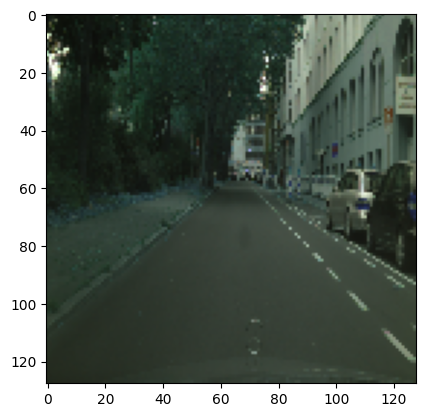

In [2]:
# Convert COLOR_MAP to a list or array for easy mapping
COLOR_MAP_LIST = np.array([rgb for rgb, class_id in sorted(COLOR_MAP.items(), key=lambda x: x[1])], dtype=np.uint8)

def class_id_to_color(class_id_mask):
    """Convert class ID mask to color-coded RGB mask."""
    # Create an empty color mask
    color_mask = np.zeros((class_id_mask.shape[0], class_id_mask.shape[1], 3), dtype=np.uint8)
    
    # Map each class ID to its corresponding color
    for class_id, color in COLOR_MAP.items():
        color_mask[class_id_mask == class_id] = color
        
    return color_mask


plt.imshow(train_input[2])

In [3]:
plt.imshow(class_id_to_color(train_labels[2]))

ValueError: operands could not be broadcast together with shapes (128,128) (3,) 

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(input_shape):
    """Build U-Net model."""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(len(COLOR_MAP), (1, 1), activation='softmax')(c9)  # Output layer

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create U-Net model
input_shape = (128, 128, 3)
model = unet_model(input_shape)

2024-11-03 06:47:14.623259: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:756] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-03 06:47:14.623342: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:756] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-03 06:47:14.624516: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-11-03 06:47:14.641799: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-11-03 06:47:14.642973: I t

In [ ]:
print(len(COLOR_MAP))

In [5]:
%env GPU_DEVICE_ORDINAL="0"
%env HIP_VISIBLE_DEVICES="0"
%env ROCR_VISIBLE_DEVICES="0,svHJ.fZYPZ0y6Yz9"
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(
    train_input, train_labels,
    validation_data=(val_input, val_labels),
    batch_size=8,
    epochs=70,
    verbose=1
)

env: GPU_DEVICE_ORDINAL="0"
env: HIP_VISIBLE_DEVICES="0"
env: ROCR_VISIBLE_DEVICES="0,svHJ.fZYPZ0y6Yz9"


2024-11-03 06:47:19.634138: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-11-03 06:47:19.635505: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


Epoch 1/70


2024-11-03 06:47:21.743329: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 584908800 exceeds 10% of free system memory.
2024-11-03 06:47:22.377379: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48742400 exceeds 10% of free system memory.
2024-11-03 06:47:22.422649: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-11-03 06:47:22.424866: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-11-03 06:47:22.425827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-11-03 06:47:22.438487: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-11-03 06:47:22.440315: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-11-03 06:47:22.451015: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-11-03 06:47:22.452611: I tensorflow/core/common_runtime/gpu_fu

 14/372 [>.............................] - ETA: 17:18 - loss: 3.4753 - accuracy: 0.2747

KeyboardInterrupt: 

In [ ]:

# Convert COLOR_MAP to a list or array for easy mapping
COLOR_MAP_LIST = np.array([rgb for rgb, class_id in sorted(COLOR_MAP.items(), key=lambda x: x[1])], dtype=np.uint8)

def class_id_to_color(class_id_mask):
    """Convert class ID mask to color-coded RGB mask."""
    # Create an empty color mask
    color_mask = np.zeros((class_id_mask.shape[0], class_id_mask.shape[1], 3), dtype=np.uint8)
    
    # Map each class ID to its corresponding color
    for class_id, color in COLOR_MAP.items():
        color_mask[class_id_mask == class_id] = color
        
    return color_mask

def plot_training_history(history):
    """Plot training and validation loss/accuracy."""
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

def visualize_predictions(model, images, labels):
    preds = model.predict(images)
    preds = np.argmax(preds, axis=-1)
    # Visualize the first image in the 1batch and its corresponding label
    cnt = 0
    for prediction in preds:
        plt.figure(figsize=(12, 6))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(images[cnt])
        plt.axis('off')

        # Ground truth
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(labels[cnt])  # Convert label to color
        plt.axis('off')

        # Model predictions
        plt.subplot(1, 3, 3)
        plt.title("Model Predictions")
        plt.imshow(prediction) # Show the first prediction
        plt.axis('off')
        cnt += 1

    plt.show()

# Visualize predictions
visualize_predictions(model, test_input[:10], test_labels[:10])

In [ ]:
def iou(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def precision(y_true, y_pred, smooth=1e-6):
    true_positives = np.sum(y_true * y_pred)
    predicted_positives = np.sum(y_pred)
    return (true_positives + smooth) / (predicted_positives + smooth)

def recall(y_true, y_pred, smooth=1e-6):
    true_positives = np.sum(y_true * y_pred)
    possible_positives = np.sum(y_true)
    return (true_positives + smooth) / (possible_positives + smooth)

# Assuming X_test and y_test are your test images and masks
threshold = 0.5  # Threshold to binarize predictions if using sigmoid output
ious, dices, precisions, recalls = [], [], [], []

for i in range(len(test_input)):
    img = test_input[i]
    true_mask = test_labels[i]

    # Get model prediction and binarize
    pred_mask = model.predict(img[np.newaxis, ...])[0]
    pred_mask = (pred_mask > threshold).astype(np.float32)  # Apply threshold for binary mask

    # Calculate metrics
    ious.append(iou(true_mask, pred_mask))
    dices.append(dice_coefficient(true_mask, pred_mask))
    precisions.append(precision(true_mask, pred_mask))
    recalls.append(recall(true_mask, pred_mask))

# Calculate mean metrics
mean_iou = np.mean(ious)
mean_dice = np.mean(dices)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice Coefficient: {mean_dice:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
